In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/home/yu/MachineLearning/"))
from machine_learning_utility import *

In [2]:
# get the training data
df = pd.read_csv('train.csv', header=0)

In [4]:
def data_cleanup(df):
    ## Method to clean up input dataframe. This is a collection of steps used above

    # add a column of Gender
    df["Gender"] = df["Sex"] == df["Sex"].unique()[0]
    df["Gender"] = df["Gender"].astype(int)
    
    # fill unknown age with median based on pclass and gender
    median_age = df.groupby(['Pclass', 'Gender']).median()['Age']
    df['AgeFill'] = df['Age']
    for pclass in df['Pclass'].unique():
        for gender in df['Gender'].unique():
            df.loc[(df['AgeFill'].isnull()) & (df['Pclass']==pclass) & (df['Gender']==gender),'AgeFill'] = median_age[pclass][gender]
    df['AgeIsNull'] = df['Age'].isnull().astype(int)    

    # fill unknown fare with median based on pclass
    median_fare = df.groupby('Pclass').median()['Fare']
    df['FareFill'] = df['Fare']
    for pclass in df['Pclass'].unique():
        df.loc[(df['FareFill'].isnull()) & (df['Pclass']==pclass),'FareFill'] = median_fare[pclass]
    df['FareIsNull'] = df['Fare'].isnull().astype(int)    
    
    # add some features
    df['FamilySize'] = df['Parch'] + df['SibSp']
    df['Age*Pclass'] = df['AgeFill']*df['Pclass']
    
    # convert Embarded to numerical values
    df.Embarked.fillna(value = df.Embarked.dropna().mode()[0], inplace=True)
    port_dict = {p: i for (i, p) in enumerate(df.Embarked.unique())}
    df['Embarked_n'] = df['Embarked'].map(lambda x: port_dict[x]) 
    
    return df

In [83]:
# read and clean up train data again using data_cleanup
train_df = pd.read_csv('train.csv', header=0)
train_df = data_cleanup(train_df)

In [6]:
# read and clean up test data
test_df = pd.read_csv('test.csv', header=0)
test_df = data_cleanup(test_df)

In [7]:
set(test_df.columns.values) 

{'Age',
 'Age*Pclass',
 'AgeFill',
 'AgeIsNull',
 'Cabin',
 'Embarked',
 'Embarked_n',
 'FamilySize',
 'Fare',
 'FareFill',
 'FareIsNull',
 'Gender',
 'Name',
 'Parch',
 'PassengerId',
 'Pclass',
 'Sex',
 'SibSp',
 'Ticket'}

In [8]:
# fitting with random forest
features = ['AgeFill', 'Pclass', 'FareFill', 'Gender', 'FamilySize', 'Embarked_n']
label = 'Survived'
x_train, x_test, y_train, y_test = train_test_split(train_df[features], train_df[label])
rf_clf = RandomForestClassifier(n_estimators=1000, criterion='entropy')
rf_clf.fit(x_train, y_train)
rf_clf.score(x_test, y_test)

0.78026905829596416

In [9]:
# make prediction
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(train_df[features], train_df[label])
test_df[label] = rf_clf.predict(test_df[features])
test_df[['PassengerId', 'Survived']].to_csv('./test_label-'+str(datetime.date.today())+'.csv', index = None)
# leader board:0.77

In [32]:
# Try random forest with gridsearchcv
tuned_parameters = {'n_estimators': [100, 150, 200, 250], 
                    'max_depth': [2, 4, 8, 16], 'criterion': ['entropy', 'gini']}
features = ['AgeFill', 'Pclass', 'FareFill', 'Gender', 'FamilySize', 'Embarked_n', 'PassengerId']
label = 'Survived'
rf_clf = gridsearchcv_wrapper(RandomForestClassifier(min_samples_leaf=10, max_features='sqrt', oob_score=True), tuned_parameters, train_df[features], train_df[label])
test_df[label] = rf_clf.predict(test_df[features])
test_df[['PassengerId', 'Survived']].to_csv('./test_label-'+str(datetime.date.today())+'.csv', index = None)
# leader boarder: 0.7799 for some parameter set. not a significant improvement though.

# Tuning hyper-parameters for accuracy
()
Best parameters set found on development set:

{'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 16}
()
Grid scores on development set:
()
0.809 (+/-0.032) for {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 2}
0.798 (+/-0.028) for {'n_estimators': 150, 'criterion': 'entropy', 'max_depth': 2}
0.794 (+/-0.034) for {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 2}
0.792 (+/-0.043) for {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 2}
0.818 (+/-0.009) for {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 4}
0.804 (+/-0.023) for {'n_estimators': 150, 'criterion': 'entropy', 'max_depth': 4}
0.815 (+/-0.007) for {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 4}
0.816 (+/-0.021) for {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 4}
0.819 (+/-0.009) for {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 8}
0.823 (+/-0.031) for {'n_estimators': 150, 'criterion': 'entrop

In [33]:
rf_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=16, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

## Useful references
* How to tune randome forest (https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/)
  * n_estimator
  * min_samples_leaf
  * max_features
* A detailed tutorial to achieve 0.81 on leader board (http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html)
  * Use stratified kfold
  * Use ExtraTreesClassifier + SelectFromModel to reduce dimensionality
  * How to convert multiclass features to multifeatures of binary class. use dummies.
  * Proper normalization

In [79]:
# Convert categorical data to a collection of binary data
def add_dummies(df, categories):
## add columns named category_i's to df
    for c in categories:
        dummies = pd.get_dummies(df[c], prefix=c)
        df = pd.concat([df, dummies], ignore_index=False, axis=1)
    return df

In [84]:
# convert Pclass and Embarked_n to dummies
train_df = add_dummies(train_df, ['Pclass', 'Embarked_n'])

In [85]:
train_df.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'Gender', u'AgeFill', u'AgeIsNull', u'FareFill', u'FareIsNull',
       u'FamilySize', u'Age*Pclass', u'Embarked_n', u'Pclass_1', u'Pclass_2',
       u'Pclass_3', u'Embarked_n_0', u'Embarked_n_1', u'Embarked_n_2'],
      dtype='object')

In [ ]:
# Try random forest with gridsearchcv
tuned_parameters = {'n_estimators': [100, 150, 200, 250], 
                    'max_depth': [2, 4, 8, 16], 'criterion': ['entropy', 'gini']}
features = ['AgeFill', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'FareFill', 'Gender', 'FamilySize', 'Embarked_n_0', 
            'Embarked_n_1', 'Embarked_n_2', 'PassengerId']
label = 'Survived'
rf_clf = gridsearchcv_wrapper(RandomForestClassifier(min_samples_leaf=10, max_features='sqrt', oob_score=True), tuned_parameters, train_df[features], train_df[label])
test_df = add_dummies(test_df, ['Pclass', 'Embarked_n'])
test_df[label] = rf_clf.predict(test_df[features])
test_df[['PassengerId', 'Survived']].to_csv('./test_label-'+str(datetime.date.today())+'.csv', index = None)
# 0.77512 same as above

# Tuning hyper-parameters for accuracy
()


## TODO

### Extract features
### normalize features

In [10]:
# fitting with KNN. Even with overfitting, score is about 0.75
knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(x_train, y_train)
knn_clf.score(x_test, y_test)

0.68609865470852016

In [100]:
# gridsearchcv wrapper
def gridsearchcv_wrapper(model, parameters, x, y, scores = ['accuracy']):
    ### wrapper for GridSearchCV
    ### model: model to be optimized
    ### parameters: parameter space for gridsearchcv
    ### x, y: training set
    ### scores: list of scoring functions
    
    # get train and test data
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, random_state = 0, test_size = 0.01)
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        cross_valid = cross_validation.StratifiedKFold(y_train)
        clf = GridSearchCV(model, parameters, cv=cross_valid,
                           scoring=score)
        clf.fit(x_train, y_train)

        print("Best parameters set found on development set:")
        print
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        for params, mean_score, scores in clf.grid_scores_:
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(x_test)
        print(classification_report(y_true, y_pred))
        print()
    return clf.best_estimator_

In [180]:
# gridsearch with SVM
tuned_parameters = {'C': np.arange(10, 200, 10), 'gamma': np.arange(1e-4, 1e-2, 5e-4), 'kernel': ['rbf']}
svm_clf = gridsearchcv_wrapper(svm.SVC(), tuned_parameters, train_df[features], train_df[label])
test_df[label] = svm_clf.predict(test_df[features])
test_df[['PassengerId', 'Survived']].to_csv('./test_label-'+str(datetime.date.today())+'.csv', index = None)
# leader board: 0.7559, worse than gender model

# Tuning hyper-parameters for accuracy
()
Best parameters set found on development set:

{'kernel': 'rbf', 'C': 90, 'gamma': 0.0021000000000000003}
()
Grid scores on development set:
()
0.687 (+/-0.025) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.724 (+/-0.007) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.00060000000000000006}
0.737 (+/-0.028) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0011000000000000001}
0.764 (+/-0.046) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0016000000000000001}
0.772 (+/-0.028) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0021000000000000003}
0.783 (+/-0.022) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0026000000000000003}
0.775 (+/-0.016) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0031000000000000003}
0.778 (+/-0.025) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0036000000000000003}
0.780 (+/-0.020) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0041000000000000003}
0.782 (+/-0.018) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0046000000000000008}
0.782 (+/-0.025) for {'kerne

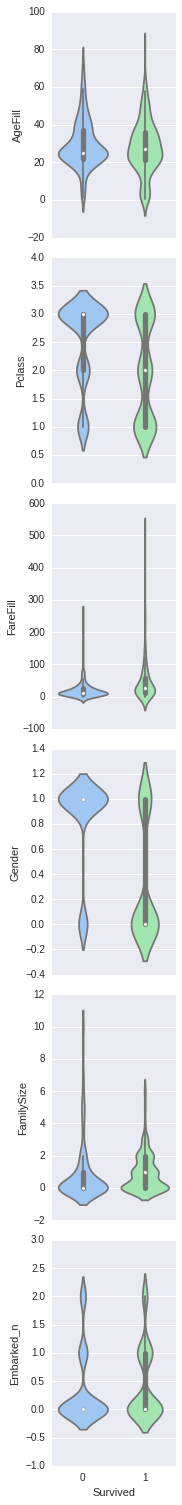

In [179]:
# some visualization
g = sns.PairGrid(train_df,
                 x_vars=["Survived"],
                 y_vars=features,
                 aspect=.75, size=3.5)
g.map(sns.violinplot, palette="pastel");


In [11]:
# fitting with NB. 
nb_clf = KNeighborsClassifier(n_neighbors=1)
nb_clf.fit(x_train, y_train)
nb_clf.score(x_test, y_test)

0.68609865470852016

In [15]:
# try logistic
from sklearn import linear_model
features = ['AgeFill', 'Gender', 'FareFill']
tuned_parameters = {'C': np.logspace(-2, 5, 10)}

logistic_clf = gridsearchcv_wrapper(linear_model.LogisticRegression(dual=False), tuned_parameters,
                                   train_df[features], train_df[label])
test_df[label] = logistic_clf.predict(test_df[features])
test_df[['PassengerId', 'Survived']].to_csv('./test_label-'+str(datetime.date.today())+'.csv', index = None)
# leader boarder: 0.7464, worse than gender model

# Tuning hyper-parameters for accuracy
()
Best parameters set found on development set:

{'C': 0.059948425031894091}
()
Grid scores on development set:
()
0.688 (+/-0.021) for {'C': 0.01}
0.785 (+/-0.021) for {'C': 0.059948425031894091}
0.782 (+/-0.021) for {'C': 0.35938136638046275}
0.782 (+/-0.021) for {'C': 2.1544346900318843}
0.782 (+/-0.021) for {'C': 12.915496650148841}
0.782 (+/-0.021) for {'C': 77.426368268112697}
0.782 (+/-0.021) for {'C': 464.15888336127819}
0.782 (+/-0.021) for {'C': 2782.5594022071259}
0.782 (+/-0.021) for {'C': 16681.005372000593}
0.782 (+/-0.021) for {'C': 100000.0}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

          0       0.75      0.84      0.80        51
          1       0.76      0.64      0.69        39

avg / total       0.76      0.76      0.75        90

()


In [93]:
np.arccosh(1.0 - 1e-15j)

(3.1622776601683792e-08-3.1622776601683792e-08j)

In [97]:
np.arccosh(1.000001)

0.00141421344446382

In [99]:
np.random.poisson.(lam=0, size=5)

array([0, 0, 0, 0, 0])